# <center>Библиотеки Python для Data Science: продолжение<center>

## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной (0 или 1, а НЕ вероятность) для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 6 дней после окончания последнего вебинара (до 20:00 вс).
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и построения признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

## Подготовка данных

In [1]:
#pip install catboost

In [2]:
#pip install xgboost

In [3]:
#pip install lightgbm

In [4]:
#pip install hyperopt

Подключение библиотек и скриптов

In [5]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from catboost import CatBoostClassifier, cv, Pool
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

# 6. Всякие разности
from sklearn.preprocessing import LabelEncoder

In [6]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

Пути к директориям и файлам

In [7]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

Оптимизация объема памяти, занимаемого датасетом

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Функции

In [9]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [10]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Загрузка данных**

In [11]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
reduce_mem_usage(df_train)
df_train.head()

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [12]:
df_train.shape

(7500, 17)

In [13]:
df_train['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

In [14]:
df_test = pd.read_csv(TEST_DATASET_PATH)
reduce_mem_usage(df_test)
df_test.head()

Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.500000,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.700001,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.700000,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.000000,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.600000,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [15]:
df_test.shape

(2500, 16)

Количество строк в датасетах:

In [16]:
print('Строк в трейне:', df_train.shape[0])
print('Строк в тесте', df_test.shape[0])

Строк в трейне: 7500
Строк в тесте 2500


In [17]:
df_train.shape[1] - 1 == df_test.shape[1]

True

## Выбросы и пропуски

Количественные переменные

In [18]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

Номинативные переменные

In [20]:
df_train.describe(include=['category', 'object', 'bool'])

,Home Ownership,Years in current job,Purpose,Term
count,7500,7129,7500,7500
unique,4,11,15,2
top,Home Mortgage,10+ years,debt consolidation,Short Term
freq,3637,2332,5944,5556


In [21]:
df_train.select_dtypes(include=['category','object', 'bool']).columns.tolist()

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [22]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Text(0.5, 1.0, 'Home Ownership')

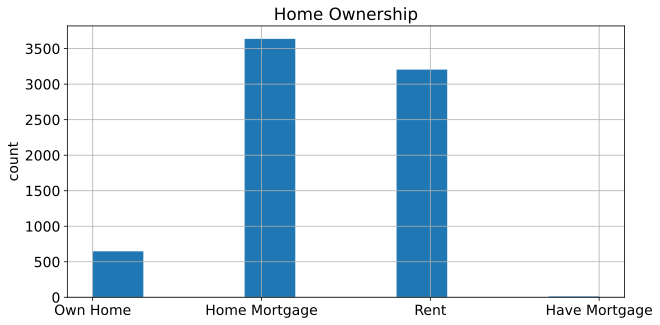

In [23]:
plt.figure(figsize = (10, 5))

df_train['Home Ownership'].hist(bins=10)
plt.ylabel('count')
plt.title('Home Ownership')

In [24]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

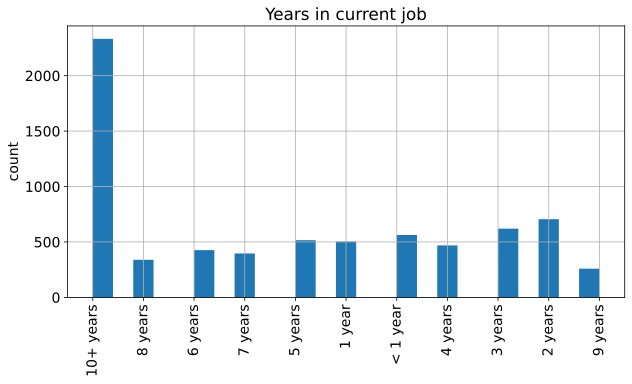

In [25]:
plt.figure(figsize = (10, 5))

df_train['Years in current job'].hist(bins=25)
plt.ylabel('count')
plt.title('Years in current job')
plt.xticks(rotation=90)

In [26]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

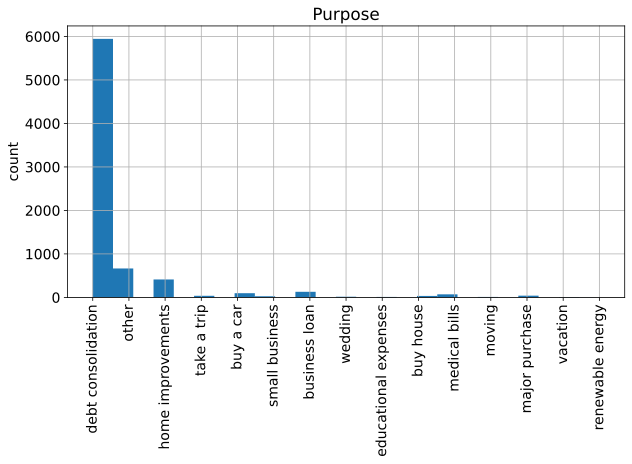

In [27]:
plt.figure(figsize = (10, 5))

df_train['Purpose'].hist(bins=25)
plt.ylabel('count')
plt.title('Purpose')
plt.xticks(rotation=90)

In [28]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

Text(0.5, 1.0, 'Term')

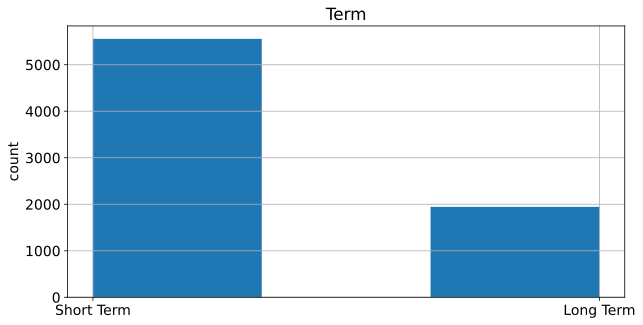

In [29]:
plt.figure(figsize = (10, 5))

df_train['Term'].hist(bins=3)
plt.ylabel('count')
plt.title('Term')

## Обработка пропусков

In [30]:
df_train.isna()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
7496,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7497,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
7498,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False


In [31]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

### Annual Income

In [32]:
df_train['Annual Income'].value_counts()

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64

меняем пустые значения на медиану

In [33]:
median = df_train['Annual Income'].median()
df_train['Annual Income'].fillna(median, inplace=True)

In [34]:
df_train['Annual Income'].isna().sum()

0

### Years in current job

In [35]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Меняем пустые значения на значение '< 1 year'

In [36]:
df_train['Years in current job'] = df_train['Years in current job'].fillna('< 1 year')

In [37]:
df_train['Years in current job'].isna().sum()

0

### Months since last delinquent

In [38]:
df_train['Months since last delinquent'].value_counts()

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

меняем пустые значения на медиану

In [39]:
median = df_train['Months since last delinquent'].median()
df_train['Months since last delinquent'].fillna(median, inplace=True)

In [40]:
df_train['Months since last delinquent'].isna().sum()

0

### Bankruptcies

In [41]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

меняем пустые значения на медиану

In [42]:
median = df_train['Bankruptcies'].median()
df_train['Bankruptcies'].fillna(median, inplace=True)

In [43]:
df_train['Bankruptcies'].isna().sum()

0

### Credit Score

In [44]:
df_train['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

In [45]:
median = df_train['Credit Score'].median()
df_train['Credit Score'].fillna(median, inplace=True)

In [46]:
df_train['Credit Score'].isna().sum()

0

### Проверка

In [47]:
df_train.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 7500 non-null   float32 
 2   Years in current job          7500 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  7500 non-null   float32 
 9   Bankruptcies                  7500 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [49]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,< 1 year,0.0,11.0,26.299999,685960.0,1.0,32.0,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,32.0,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


## Создадим копию датасета для финальной обработки в catboost

In [50]:
train_mod = df_train.copy()

# Базовая проверка датасета на различных моделях

### Преобразуем категориальные признаки в числовые для использования в алгоритмах бустинга

In [51]:
df_train["Home Ownership"] = LabelEncoder().fit_transform(df_train["Home Ownership"])

In [52]:
df_train["Years in current job"] = LabelEncoder().fit_transform(df_train["Years in current job"])

In [53]:
df_train["Purpose"] = LabelEncoder().fit_transform(df_train["Purpose"])

In [54]:
df_train["Term"] = LabelEncoder().fit_transform(df_train["Term"])

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   int32  
 1   Annual Income                 7500 non-null   float32
 2   Years in current job          7500 non-null   int32  
 3   Tax Liens                     7500 non-null   float32
 4   Number of Open Accounts       7500 non-null   float32
 5   Years of Credit History       7500 non-null   float32
 6   Maximum Open Credit           7500 non-null   float32
 7   Number of Credit Problems     7500 non-null   float32
 8   Months since last delinquent  7500 non-null   float32
 9   Bankruptcies                  7500 non-null   float32
 10  Purpose                       7500 non-null   int32  
 11  Term                          7500 non-null   int32  
 12  Current Loan Amount           7500 non-null   float32
 13  Cur

In [56]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,2,482087.0,10,0.0,11.0,26.299999,685960.0,1.0,32.0,1.0,3,1,100000000.0,47386.0,7914.0,749.0,0
1,2,1025487.0,1,0.0,15.0,15.300000,1181730.0,0.0,32.0,0.0,3,0,264968.0,394972.0,18373.0,737.0,1
2,1,751412.0,8,0.0,11.0,35.000000,1182434.0,0.0,32.0,0.0,3,1,100000000.0,308389.0,13651.0,742.0,0
3,2,805068.0,6,0.0,8.0,22.500000,147400.0,1.0,32.0,1.0,3,1,121396.0,95855.0,11338.0,694.0,0
4,3,776264.0,8,0.0,13.0,13.600000,385836.0,1.0,32.0,0.0,3,1,125840.0,93309.0,7180.0,719.0,0


### Разбиение на train и test

In [57]:
target_name = 'Credit Default'

In [58]:
X = df_train.drop(columns=target_name)
y = df_train[target_name]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [60]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((5025, 16), (2475, 16), (5025,), (2475,))

### Построение и оценка базовых моделей

**Логистическая регрессия**

In [61]:
%%time

model_lr = LogisticRegression(random_state=21)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.98      0.86      3611
           1       0.80      0.21      0.33      1414

    accuracy                           0.76      5025
   macro avg       0.78      0.60      0.59      5025
weighted avg       0.77      0.76      0.71      5025

TEST

              precision    recall  f1-score   support

           0       0.76      0.98      0.85      1776
           1       0.77      0.21      0.33       699

    accuracy                           0.76      2475
   macro avg       0.76      0.59      0.59      2475
weighted avg       0.76      0.76      0.71      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1732   44
1                552  147
Wall time: 137 ms


**k ближайших соседей**

In [62]:
%%time

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      3611
           1       0.66      0.43      0.52      1414

    accuracy                           0.78      5025
   macro avg       0.73      0.67      0.69      5025
weighted avg       0.76      0.78      0.76      5025

TEST

              precision    recall  f1-score   support

           0       0.74      0.84      0.78      1776
           1       0.38      0.25      0.30       699

    accuracy                           0.67      2475
   macro avg       0.56      0.54      0.54      2475
weighted avg       0.64      0.67      0.65      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1483  293
1                521  178
Wall time: 409 ms


**Бустинговые алгоритмы**

*XGBoost*

In [63]:
%%time

model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[22:28:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3611
           1       1.00      0.87      0.93      1414

    accuracy                           0.96      5025
   macro avg       0.97      0.94      0.95      5025
weighted avg       0.96      0.96      0.96      5025

TEST

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1776
           1       0.62      0.36      0.45       699

    accuracy                           0.76      2475
   macro avg       0.70      0.64      0.65      2475
weighted avg       0.74      0.76      0.73      2475

CONFUSION MATRIX

col_0

*LightGBM*

In [64]:
%%time

model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3611
           1       0.99      0.71      0.83      1414

    accuracy                           0.92      5025
   macro avg       0.94      0.85      0.89      5025
weighted avg       0.92      0.92      0.91      5025

TEST

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1776
           1       0.65      0.34      0.45       699

    accuracy                           0.76      2475
   macro avg       0.71      0.63      0.65      2475
weighted avg       0.74      0.76      0.73      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1644  132
1                459  240
Wall time: 197 ms


*CatBoost*

In [65]:
%%time

model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      3611
           1       0.97      0.57      0.72      1414

    accuracy                           0.88      5025
   macro avg       0.91      0.78      0.82      5025
weighted avg       0.89      0.88      0.86      5025

TEST

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1776
           1       0.73      0.31      0.44       699

    accuracy                           0.77      2475
   macro avg       0.75      0.63      0.65      2475
weighted avg       0.76      0.77      0.74      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1693   83
1                480  219
Wall time: 5.36 s


# Финальный вариант модели

Поскольку в датасете представлено большое количество категориальных значений выберем для финальной модели catboost

In [66]:
df = train_mod.copy()

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 7500 non-null   float32 
 2   Years in current job          7500 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  7500 non-null   float32 
 9   Bankruptcies                  7500 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [68]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES_SELECTED = df.drop(TARGET_NAME, axis=1).columns

In [69]:
X = df[FEATURE_NAMES_SELECTED]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=211)

In [70]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term'] 
print(CAT_FEATURE_NAMES)
cat_features = [i for i, col in enumerate(FEATURE_NAMES_SELECTED) if col in CAT_FEATURE_NAMES]
cat_features

['Home Ownership', 'Years in current job', 'Purpose', 'Term']


[0, 2, 10, 11]

In [71]:
scale = int(y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0])
scale

2

In [72]:
cat_model = catb.CatBoostClassifier(n_estimators=100, max_depth=4, scale_pos_weight=scale,
                                      silent=True, random_state=21)
cat_model.fit(X_train, y_train, cat_features=cat_features)

y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)
y_test_pred_probs = cat_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3778
           1       0.61      0.57      0.59      1472

    accuracy                           0.78      5250
   macro avg       0.72      0.71      0.72      5250
weighted avg       0.77      0.78      0.78      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1609
           1       0.56      0.52      0.54       641

    accuracy                           0.75      2250
   macro avg       0.69      0.68      0.68      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1347  262
1                309  332


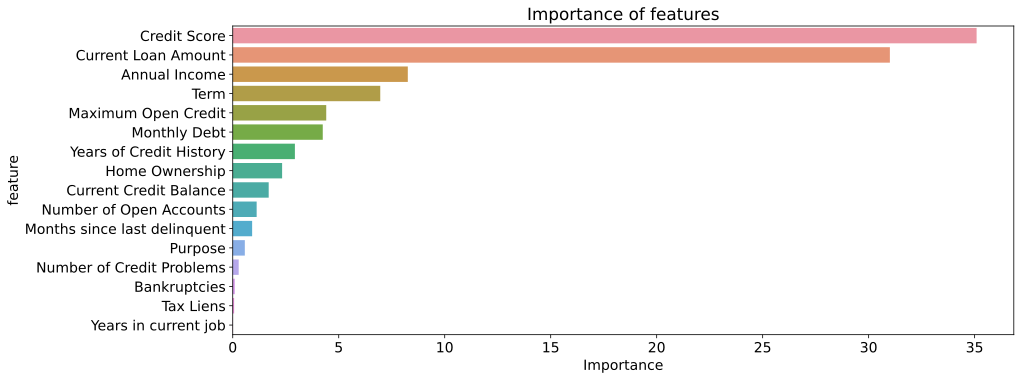

In [73]:
important_features_top = show_feature_importances(X_train.columns, 
                                                  cat_model.feature_importances_, 
                                                  get_top=15)

Результаты метрик показывают, что переобучения нет и снижение степени переобучения не требуется.

### Выбор порога вероятности для определения класса

In [74]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 6))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

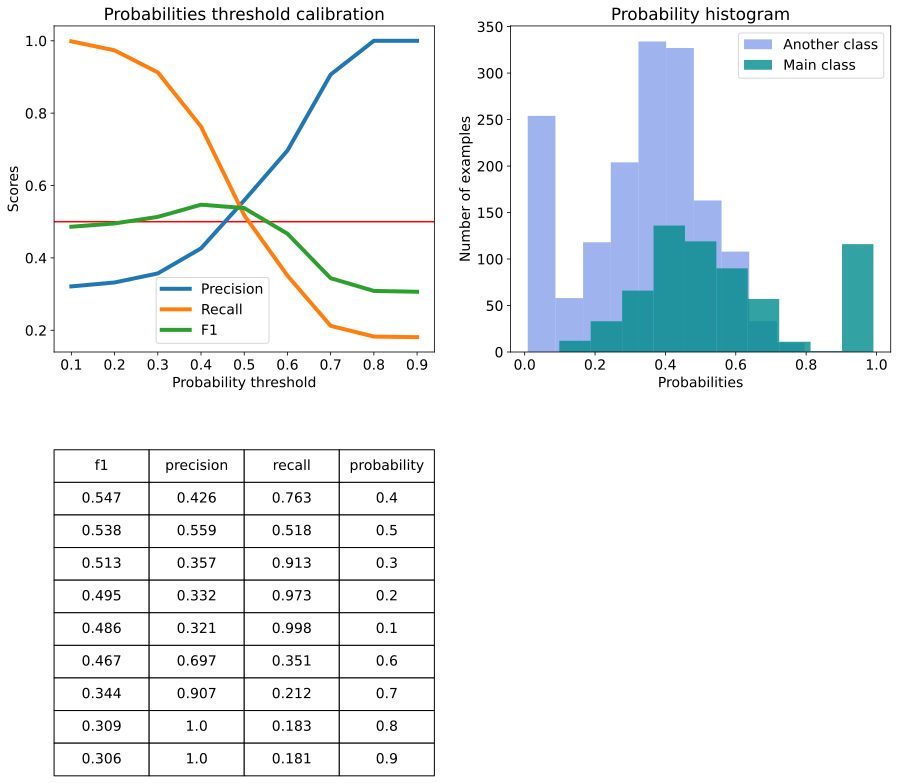

In [75]:
cat_model.fit(X_train, y_train, cat_features=cat_features)
y_test_pred_probs = cat_model.predict_proba(X_test)[:, 1]
show_proba_calibration_plots(y_test_pred_probs, y_test)

Из графика видно, что 0.5 является оптимальным параметром для порога вероятности.

## Проводим аналогичную очистку и обработку данных для тестового датасета

In [76]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                2500 non-null   category
 1   Annual Income                 1987 non-null   float32 
 2   Years in current job          2414 non-null   category
 3   Tax Liens                     2500 non-null   float32 
 4   Number of Open Accounts       2500 non-null   float32 
 5   Years of Credit History       2500 non-null   float32 
 6   Maximum Open Credit           2500 non-null   float32 
 7   Number of Credit Problems     2500 non-null   float32 
 8   Months since last delinquent  1142 non-null   float32 
 9   Bankruptcies                  2497 non-null   float32 
 10  Purpose                       2500 non-null   category
 11  Term                          2500 non-null   category
 12  Current Loan Amount           2500 non-null   fl

In [77]:
df_test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [78]:
median = df_test['Annual Income'].median()
df_test['Annual Income'].fillna(median, inplace=True)

In [79]:
df_test['Years in current job'] = df_test['Years in current job'].fillna('< 1 year')

In [80]:
median = df_test['Months since last delinquent'].median()
df_test['Months since last delinquent'].fillna(median, inplace=True)

In [81]:
median = df_test['Bankruptcies'].median()
df_test['Bankruptcies'].fillna(median, inplace=True)

In [82]:
median = df_test['Credit Score'].median()
df_test['Credit Score'].fillna(median, inplace=True)

In [83]:
df_test.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

In [84]:
final_preds = cat_model.predict(df_test)

predicted_df = pd.DataFrame(final_preds)
predicted_df.to_csv('PopovMV_predictions.csv')

In [85]:
predicted_df.head()

,0
0,0
1,1
2,1
3,0
4,0


In [86]:
print('Строк в прогнозе:', predicted_df.shape[0])

Строк в прогнозе: 2500
